# 5. Reducción de imágenes científicas 
El material de los capítulos anteriores se estaba construyendo para calibrar las imágenes científicas. Las imágenes sesgadas, oscuras y planas combinadas de los pasos anteriores se utilizan para calibrar las imágenes de cualquier objeto de interés en las imágenes científicas.

# 5.1 Dos ejemplos

In [1]:
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np

from astropy import units as u
import ccdproc as ccdp

from convenience_functions import show_image

In [2]:
# Use custom style for larger fonts and figures
plt.style.use('guide.mplstyle')

# 5.1.1. Resumen 
ccdproc proporciona un par de formas de abordar la calibración de las imágenes científicas:

    Realice cada uno de los pasos individuales manualmente usando subtract_bias, subtract_darky flat_correct.

    Utilice la ccd_processfunción para realizar todos los pasos de reducción.

Este cuaderno hará cada uno de estos en secciones separadas a continuación.

In [3]:
def find_nearest_dark_exposure(image, dark_exposure_times, tolerance=0.5):
    """
    Find the nearest exposure time of a dark frame to the exposure time of the image,
    raising an error if the difference in exposure time is more than tolerance.
    
    Parameters
    ----------
    
    image : astropy.nddata.CCDData
        Image for which a matching dark is needed.
    
    dark_exposure_times : list
        Exposure times for which there are darks.
    
    tolerance : float or ``None``, optional
        Maximum difference, in seconds, between the image and the closest dark. Set
        to ``None`` to skip the tolerance test.
    
    Returns
    -------
    
    float
        Closest dark exposure time to the image.
    """

    dark_exposures = np.array(list(dark_exposure_times))
    idx = np.argmin(np.abs(dark_exposures - image.header['exptime']))
    closest_dark_exposure = dark_exposures[idx]

    if (tolerance is not None and 
        np.abs(image.header['exptime'] - closest_dark_exposure) > tolerance):
        
        raise RuntimeError('Closest dark exposure time is {} for flat of exposure '
                           'time {}.'.format(closest_dark_exposure, a_flat.header['exptime']))
        
    
    return closest_dark_exposure

# 5.1.2. Ejemplo 1 
Los datos de este ejemplo son del chip 0 de la cámara de formato grande en el Observatorio Palomar. En cuadernos anteriores determinamos que:

    Este CCD tiene una región de sobreexploración muy útil .

    No es necesario escalar los marcos oscuros en estos datos y, por lo tanto, no es necesario restar el sesgo.

Primero, creamos ImageFileCollection s para los datos sin procesar y los datos calibrados, y definimos variables para el tipo de imagen del campo plano y las imágenes científicas (desafortunadamente, no hay nombres estándar para estos).

In [4]:
reduced_path = Path('example1-reduced')

science_imagetyp = 'object'
flat_imagetyp = 'flatfield'
exposure = 'exptime'

ifc_reduced = ccdp.ImageFileCollection(reduced_path)
ifc_raw = ccdp.ImageFileCollection('example-cryo-LFC')

In [5]:
lights = ifc_raw.summary[ifc_raw.summary['imagetyp'] == science_imagetyp.upper()]
lights['date-obs', 'file', 'object', 'filter', exposure]

date-obs,file,object,filter,exptime
str10,str14,str7,str2,float64
2016-01-16,ccd.037.0.fits,vv124_1,g',300.062
2016-01-16,ccd.043.0.fits,vv124_1,i',300.014


In [6]:
combo_calibs = ifc_reduced.summary[ifc_reduced.summary['combined'].filled(False).astype('bool')]
combo_calibs['date-obs', 'file', 'imagetyp', 'object', 'filter', exposure]

date-obs,file,imagetyp,object,filter,exptime
str10,str27,str9,str6,str2,float64
2016-01-15,combined_bias.fit,BIAS,bias,i',0.0
2016-03-13,combined_dark_ 7.000.fit,DARK,dark,r',7.0
2016-03-13,combined_dark_300.000.fit,DARK,dark,r',300.0
2016-03-13,combined_dark_70.000.fit,DARK,dark,r',70.0
2016-01-16,combined_flat_filter_g'.fit,FLATFIELD,flat_g,g',70.001
2016-01-16,combined_flat_filter_i'.fit,FLATFIELD,flat_i,i',7.0


Ambas imágenes utilizarán la exposición oscura de 300 segundos para eliminar la corriente oscura y hay una imagen de campo plano para cada uno de los dos filtros presentes en los datos.

Aunque podríamos codificar qué oscuro usar, es posible configurar un diccionario para acceder a los oscuros, con uno separado para acceder a las imágenes científicas. El objetivo es escribir código que se reutilice más convenientemente.

In [7]:
combined_darks = {ccd.header[exposure]: ccd for ccd in ifc_reduced.ccds(imagetyp='dark', combined=True)}
combined_flats = {ccd.header['filter']: ccd for ccd in ifc_reduced.ccds(imagetyp=flat_imagetyp, combined=True)}

Los pasos de calibración para cada una de estas imágenes científicas son:

    Reste el overscan de la imagen científica.

    Recorte la sobreexploración.

    Reste la corriente oscura (que en este caso también incluye la polarización).

    Corrección plana de la imagen.

Estos son los pasos mínimos necesarios para calibrar. La corrección de los datos y la identificación de los rayos cósmicos son pasos adicionales que a menudo se pueden realizar en esta etapa. En este cuaderno se discutirá la identificación de los rayos cósmicos .

In [8]:
# These two lists are created so that we have copies of the raw and calibrated images
# to later in the notebook. They are not ordinarily required.
all_reds = []
light_ccds = []
for light, file_name in ifc_raw.ccds(imagetyp=science_imagetyp, return_fname=True, ccd_kwargs=dict(unit='adu')):
    light_ccds.append(light)
    
    reduced = ccdp.subtract_overscan(light, overscan=light[:, 2055:], median=True)
    
    reduced = ccdp.trim_image(reduced[:, :2048])

    closest_dark = find_nearest_dark_exposure(reduced, combined_darks.keys())
    reduced = ccdp.subtract_dark(reduced, combined_darks[closest_dark],
                                 exposure_time=exposure, exposure_unit=u.second
                                )
    good_flat = combined_flats[reduced.header['filter']]
    reduced = ccdp.flat_correct(reduced, good_flat)
    all_reds.append(reduced)
    reduced.write(reduced_path / file_name)

C:\Users\Saike\anaconda3\lib\site-packages\astropy\units\quantity.py:486: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\Saike\anaconda3\lib\site-packages\astropy\nddata\nduncertainty.py:650: RuntimeWarning: invalid value encountered in true_divide
  return from_variance((left + right + correlation_sign * corr) /


# 5.1.2.1. Antes y después del Ejemplo 1 
La siguiente celda muestra cada imagen científica antes y después de la calibración.

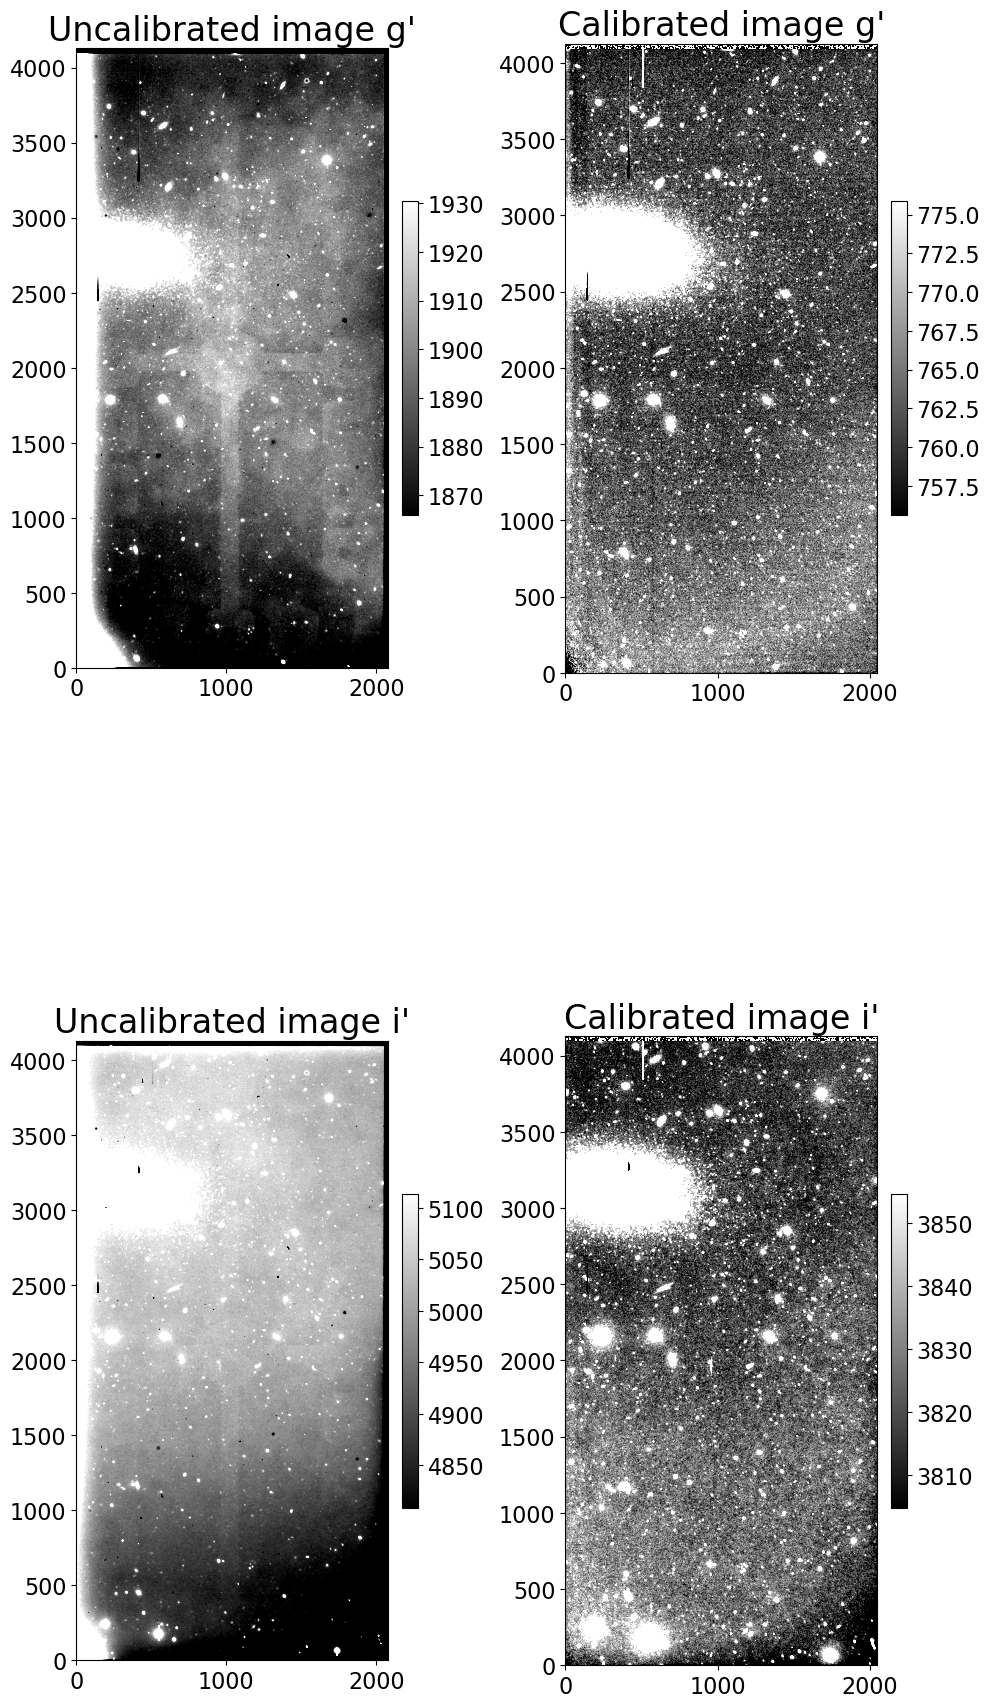

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(10, 20), tight_layout=True)

for row, raw_science_image in enumerate(light_ccds):
    filt = raw_science_image.header['filter']
    axes[row, 0].set_title('Uncalibrated image {}'.format(filt))
    show_image(raw_science_image, cmap='gray', ax=axes[row, 0], fig=fig, percl=90)

    axes[row, 1].set_title('Calibrated image {}'.format(filt))
    show_image(all_reds[row].data, cmap='gray', ax=axes[row, 1], fig=fig, percl=90)

En cada imagen reducida, se eliminó el patrón general en el campo plano y se eliminó el brillo del sensor a lo largo del borde izquierdo y en la esquina inferior izquierda de las imágenes sin calibrar. El fondo de las imágenes calibradas todavía no es perfectamente uniforme, aunque ese fondo se puede eliminar con photutils si lo desea. La columna defectuosa parcial visible en ambas imágenes sin calibrar también sigue presente en las imágenes calibradas, particularmente en el g'filtro.

Esos píxeles deberán enmascararse, como se describe en el cuaderno sobre píxeles defectuosos .

# 5.1.3. Ejemplo 2 
La cámara de este ejemplo es una Andor Aspen CG16M con refrigeración termoeléctrica. En cuadernos anteriores decidimos que:

La región de sobreexploración de esta cámara no es útil.

Para este conjunto de datos, los marcos oscuros debían escalarse, por lo que debemos restar el marco de sesgo de cada imagen científica.

Primero, creamos ImageFileCollection s para los datos sin procesar y los datos calibrados, y definimos variables para el tipo de imagen del campo plano y las imágenes científicas (desafortunadamente, no hay nombres estándar para estos).

In [10]:
reduced_path = Path('example2-reduced')

science_imagetyp = 'light'
flat_imagetyp = 'flat'
exposure = 'exposure'

ifc_reduced = ccdp.ImageFileCollection(reduced_path)
ifc_raw = ccdp.ImageFileCollection('example-thermo-electric')

In [11]:
lights = ifc_raw.summary[ifc_raw.summary['imagetyp'] == science_imagetyp.upper()]
lights['date-obs', 'file', 'object', 'filter', exposure]

date-obs,file,object,filter,exposure
str19,str31,object,object,float64
2018-08-23T09:00:21,kelt-16-b-S001-R001-C084-r.fit,kelt-16b,r,90.0
2018-08-23T10:29:30,kelt-16-b-S001-R001-C125-r.fit,kelt-16b,r,90.0


In [12]:
combo_calibs = ifc_reduced.summary[ifc_reduced.summary['combined'].filled(False).astype('bool')]
combo_calibs['date-obs', 'file', 'imagetyp', 'filter', exposure]

date-obs,file,imagetyp,filter,exposure
str19,str31,str4,object,float64
2018-08-23T11:20:07,combined_bias.fit,BIAS,--,0.0
2018-08-23T10:42:41,combined_dark_90.000.fit,DARK,--,90.0
2018-08-23T01:25:17,combined_flat_filter_r.fit,FLAT,r,1.0


Aunque solo hay una de cada tipo de imagen de calibración combinada, el siguiente código configura un diccionario para los planos y oscuros. Ese código funcionará en una noche más típica en la que puede haber varios filtros y múltiples tiempos de exposición.

In [13]:
combined_darks = {ccd.header[exposure]: ccd for ccd in ifc_reduced.ccds(imagetyp='dark', combined=True)}
combined_flats = {ccd.header['filter']: ccd for ccd in ifc_reduced.ccds(imagetyp=flat_imagetyp, combined=True)}

# There is only on bias, so no need to set up a dictionary.
combined_bias = [ccd for ccd in ifc_reduced.ccds(imagetyp='bias', combined=True)][0]

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


Los pasos de calibración para cada una de estas imágenes científicas son:

    Recorte la sobreexploración.

    Reste el sesgo, porque se restó el sesgo de los marcos oscuros.

    Reste la oscuridad, usando la oscuridad más cercana en tiempo de exposición a la imagen científica.

    Flat corrige las imágenes, usando el plano combinado cuyo filtro coincide con la imagen científica.

In [14]:
all_reds = []
light_ccds = []
for light, file_name in ifc_raw.ccds(imagetyp=science_imagetyp, return_fname=True):
    light_ccds.append(light)

    reduced = ccdp.trim_image(light[:, :4096])
    
    # Note that the first argument in the remainder of the ccdproc calls is
    # the *reduced* image, so that the calibration steps are cumulative.
    reduced = ccdp.subtract_bias(reduced, combined_bias)
    
    closest_dark = find_nearest_dark_exposure(reduced, combined_darks.keys())

    reduced = ccdp.subtract_dark(reduced, combined_darks[closest_dark], 
                                 exposure_time='exptime', exposure_unit=u.second)
    
    good_flat = combined_flats[reduced.header['filter']]
    reduced = ccdp.flat_correct(reduced, good_flat)
    all_reds.append(reduced)
    reduced.write(reduced_path / file_name)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


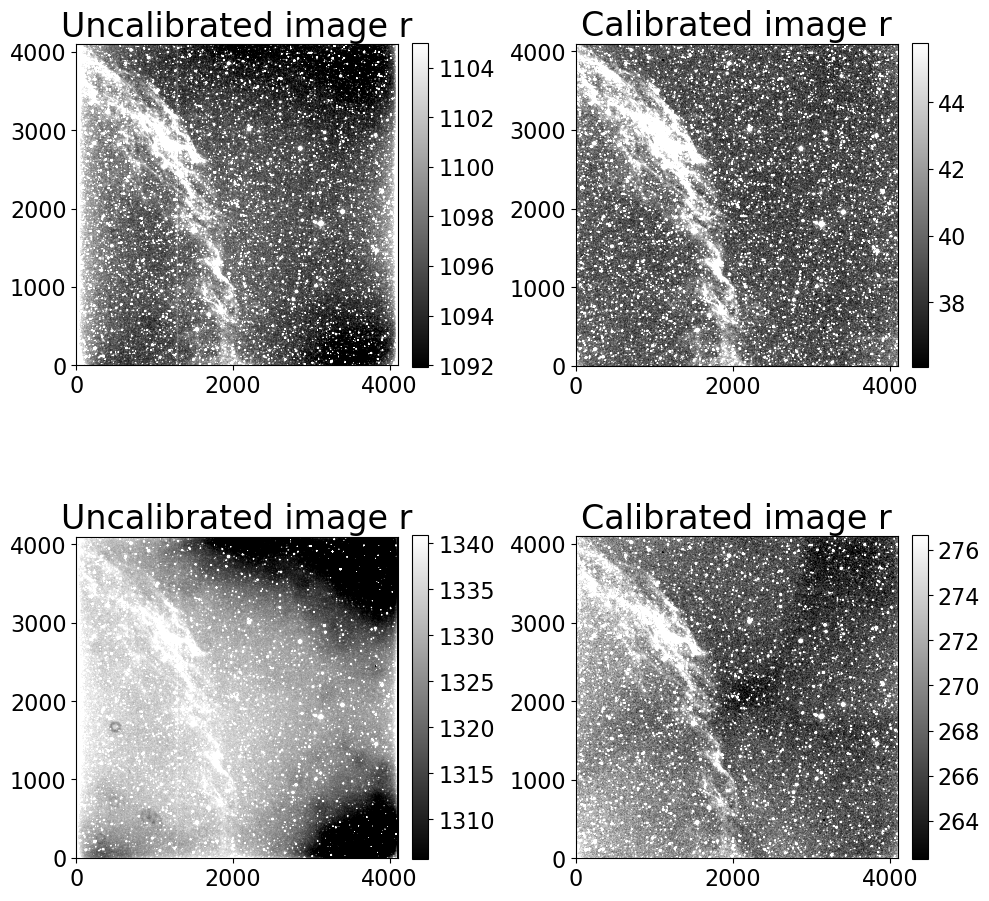

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), tight_layout=True)

for row, raw_science_image in enumerate(light_ccds):
    filt = raw_science_image.header['filter']
    axes[row, 0].set_title('Uncalibrated image {}'.format(filt))
    show_image(raw_science_image, cmap='gray', ax=axes[row, 0], fig=fig, percl=90)

    axes[row, 1].set_title('Calibrated image {}'.format(filt))
    show_image(all_reds[row].data, cmap='gray', ax=axes[row, 1], fig=fig, percl=90)

En ambas imágenes, la mayor parte de la falta de uniformidad en el fondo se eliminó a lo largo de la columna brillante y el sensor brilla en los bordes izquierdo y derecho de las imágenes sin calibrar.

La imagen calibrada en la fila superior parece que la corrección plana ha llevado a un fondo bastante uniforme. El fondo de la imagen de la segunda fila no es tan uniforme. Resulta que la segunda imagen se tomó mucho más cerca del amanecer que la primera imagen, por lo que el fondo del cielo en realidad no era uniforme cuando se tomó la imagen.